In [1]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [2]:
from numpy.random import seed
import tensorflow

RANDOM_SEED = 7

seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [3]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


C:\Users\admin\anaconda3\envs\kaggle_korwin_ds_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\admin\anaconda3\envs\kaggle_korwin_ds_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


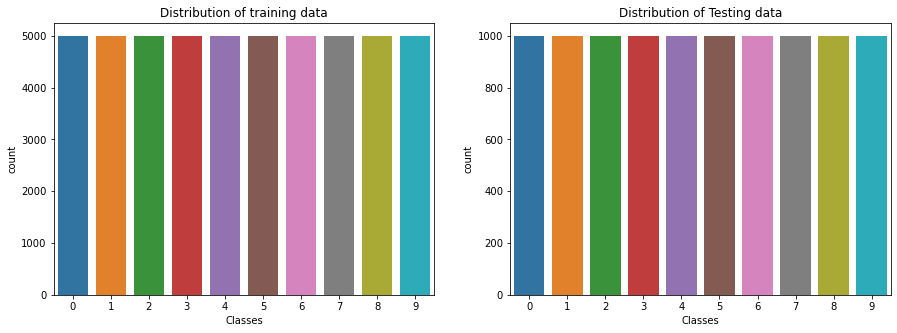

In [5]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [6]:
import tensorflow

# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [7]:
#define the convnet
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.05)

cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath="C:/Users/admin/Desktop/Programming/Python/pythonProject1/saved_models", 
    verbose=1, 
    save_weights_only=True,
    save_freq= 5)

model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'),
#     Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
#     Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [9]:
data_augmentation

False

In [10]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[early_stopping_callback, cp_callback]
            )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(
        datagen.flow(x_train, y_train,
        batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        workers=4,
        callbacks=[early_stopping_callback, cp_callback]
    )

Not using data augmentation.
Epoch 1/100
   4/1563 [..............................] - ETA: 19s - loss: 2.3668 - accuracy: 0.1094
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
   6/1563 [..............................] - ETA: 29s - loss: 2.3747 - accuracy: 0.1042
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  14/1563 [..............................] - ETA: 30s - loss: 2.3461 - accuracy: 0.0893
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  18/1563 [..............................] - ETA: 33s - loss: 2.3352 - accuracy: 0.0938
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  24/1563 [..............................] - ETA: 40s - loss: 2.3220 - accuracy: 0.0977
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  29/1563 [.............

 224/1563 [===>..........................] - ETA: 27s - loss: 1.9800 - accuracy: 0.2759
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 226/1563 [===>..........................] - ETA: 27s - loss: 1.9796 - accuracy: 0.2759
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 234/1563 [===>..........................] - ETA: 27s - loss: 1.9739 - accuracy: 0.2775
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 236/1563 [===>..........................] - ETA: 27s - loss: 1.9720 - accuracy: 0.2787
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 244/1563 [===>..........................] - ETA: 27s - loss: 1.9642 - accuracy: 0.2805
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 246/1563 [===>..........................] - ETA: 27s - loss: 1.9

 443/1563 [=======>......................] - ETA: 23s - loss: 1.8265 - accuracy: 0.3351
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 448/1563 [=======>......................] - ETA: 23s - loss: 1.8239 - accuracy: 0.3370
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 453/1563 [=======>......................] - ETA: 23s - loss: 1.8222 - accuracy: 0.3377
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 458/1563 [=======>......................] - ETA: 23s - loss: 1.8194 - accuracy: 0.3386
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 463/1563 [=======>......................] - ETA: 22s - loss: 1.8168 - accuracy: 0.3398
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 468/1563 [=======>......................] - ETA: 22s - loss: 1.8

 663/1563 [===========>..................] - ETA: 19s - loss: 1.7300 - accuracy: 0.3716
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 669/1563 [===========>..................] - ETA: 19s - loss: 1.7277 - accuracy: 0.3725
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 671/1563 [===========>..................] - ETA: 19s - loss: 1.7269 - accuracy: 0.3729
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 679/1563 [============>.................] - ETA: 19s - loss: 1.7240 - accuracy: 0.3743
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 681/1563 [============>.................] - ETA: 19s - loss: 1.7236 - accuracy: 0.3741
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 689/1563 [============>.................] - ETA: 19s - loss: 1.7

 884/1563 [===============>..............] - ETA: 14s - loss: 1.6662 - accuracy: 0.3954
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 886/1563 [================>.............] - ETA: 14s - loss: 1.6656 - accuracy: 0.3955
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 894/1563 [================>.............] - ETA: 14s - loss: 1.6644 - accuracy: 0.3958
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 896/1563 [================>.............] - ETA: 14s - loss: 1.6639 - accuracy: 0.3960
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 904/1563 [================>.............] - ETA: 14s - loss: 1.6636 - accuracy: 0.3963
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 906/1563 [================>.............] - ETA: 14s - loss: 1.6

1101/1563 [====================>.........] - ETA: 9s - loss: 1.6161 - accuracy: 0.4148 
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1109/1563 [====================>.........] - ETA: 9s - loss: 1.6145 - accuracy: 0.4154
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1111/1563 [====================>.........] - ETA: 9s - loss: 1.6140 - accuracy: 0.4157
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1119/1563 [====================>.........] - ETA: 9s - loss: 1.6128 - accuracy: 0.4165
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1121/1563 [====================>.........] - ETA: 9s - loss: 1.6124 - accuracy: 0.4168
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1129/1563 [====================>.........] - ETA: 9s - loss: 1.6109 -

1324/1563 [========================>.....] - ETA: 5s - loss: 1.5785 - accuracy: 0.4294
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1328/1563 [========================>.....] - ETA: 5s - loss: 1.5777 - accuracy: 0.4296
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1333/1563 [========================>.....] - ETA: 5s - loss: 1.5769 - accuracy: 0.4300
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1338/1563 [========================>.....] - ETA: 4s - loss: 1.5759 - accuracy: 0.4304
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1342/1563 [========================>.....] - ETA: 4s - loss: 1.5754 - accuracy: 0.4307
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1348/1563 [========================>.....] - ETA: 4s - loss: 1.5744 - 

1544/1563 [============================>.] - ETA: 0s - loss: 1.5423 - accuracy: 0.4431
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1546/1563 [============================>.] - ETA: 0s - loss: 1.5419 - accuracy: 0.4433
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1554/1563 [============================>.] - ETA: 0s - loss: 1.5405 - accuracy: 0.4438
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1556/1563 [============================>.] - ETA: 0s - loss: 1.5399 - accuracy: 0.4440
Epoch 00001: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5384 - accuracy: 0.4445 - val_loss: 1.2372 - val_accuracy: 0.5593
Epoch 2/100
   1/1563 [..............................] - ETA: 0s - loss: 1.4689 - accuracy: 0.5938
Epoch 00002: saving mo

 195/1563 [==>...........................] - ETA: 29s - loss: 1.2728 - accuracy: 0.5381
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 200/1563 [==>...........................] - ETA: 29s - loss: 1.2741 - accuracy: 0.5389
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 206/1563 [==>...........................] - ETA: 29s - loss: 1.2691 - accuracy: 0.5405
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 211/1563 [===>..........................] - ETA: 29s - loss: 1.2668 - accuracy: 0.5409
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 213/1563 [===>..........................] - ETA: 29s - loss: 1.2663 - accuracy: 0.5405
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 221/1563 [===>..........................] - ETA: 29s - loss: 1.2

 413/1563 [======>.......................] - ETA: 24s - loss: 1.2655 - accuracy: 0.5418
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 421/1563 [=======>......................] - ETA: 24s - loss: 1.2651 - accuracy: 0.5424
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 423/1563 [=======>......................] - ETA: 24s - loss: 1.2656 - accuracy: 0.5420
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 431/1563 [=======>......................] - ETA: 23s - loss: 1.2649 - accuracy: 0.5426
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 433/1563 [=======>......................] - ETA: 23s - loss: 1.2654 - accuracy: 0.5423
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 441/1563 [=======>......................] - ETA: 23s - loss: 1.2

 633/1563 [===========>..................] - ETA: 19s - loss: 1.2575 - accuracy: 0.5440
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 641/1563 [===========>..................] - ETA: 18s - loss: 1.2574 - accuracy: 0.5437
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 643/1563 [===========>..................] - ETA: 18s - loss: 1.2571 - accuracy: 0.5438
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 651/1563 [===========>..................] - ETA: 18s - loss: 1.2571 - accuracy: 0.5438
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 653/1563 [===========>..................] - ETA: 18s - loss: 1.2571 - accuracy: 0.5436
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 661/1563 [===========>..................] - ETA: 18s - loss: 1.2

 855/1563 [===============>..............] - ETA: 14s - loss: 1.2495 - accuracy: 0.5486
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 860/1563 [===============>..............] - ETA: 14s - loss: 1.2485 - accuracy: 0.5491
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 865/1563 [===============>..............] - ETA: 14s - loss: 1.2476 - accuracy: 0.5495
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 870/1563 [===============>..............] - ETA: 14s - loss: 1.2475 - accuracy: 0.5498
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 875/1563 [===============>..............] - ETA: 14s - loss: 1.2473 - accuracy: 0.5501
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 880/1563 [===============>..............] - ETA: 14s - loss: 1.2

1073/1563 [===================>..........] - ETA: 10s - loss: 1.2409 - accuracy: 0.5541
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1081/1563 [===================>..........] - ETA: 10s - loss: 1.2408 - accuracy: 0.5543
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1083/1563 [===================>..........] - ETA: 10s - loss: 1.2404 - accuracy: 0.5546
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1091/1563 [===================>..........] - ETA: 10s - loss: 1.2401 - accuracy: 0.5549
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1093/1563 [===================>..........] - ETA: 10s - loss: 1.2400 - accuracy: 0.5548
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1101/1563 [====================>.........] - ETA: 9s - loss: 1.23

1296/1563 [=======================>......] - ETA: 5s - loss: 1.2319 - accuracy: 0.5589
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1298/1563 [=======================>......] - ETA: 5s - loss: 1.2315 - accuracy: 0.5591
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1306/1563 [========================>.....] - ETA: 5s - loss: 1.2320 - accuracy: 0.5588
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1311/1563 [========================>.....] - ETA: 5s - loss: 1.2317 - accuracy: 0.5590
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1313/1563 [========================>.....] - ETA: 5s - loss: 1.2316 - accuracy: 0.5591
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1321/1563 [========================>.....] - ETA: 5s - loss: 1.2318 - 

1516/1563 [============================>.] - ETA: 1s - loss: 1.2196 - accuracy: 0.5639
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1520/1563 [============================>.] - ETA: 0s - loss: 1.2192 - accuracy: 0.5641
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1525/1563 [============================>.] - ETA: 0s - loss: 1.2191 - accuracy: 0.5642
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1529/1563 [============================>.] - ETA: 0s - loss: 1.2198 - accuracy: 0.5642
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1535/1563 [============================>.] - ETA: 0s - loss: 1.2197 - accuracy: 0.5641
Epoch 00002: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1540/1563 [============================>.] - ETA: 0s - loss: 1.2196 - 

 168/1563 [==>...........................] - ETA: 36s - loss: 1.0944 - accuracy: 0.6107
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 172/1563 [==>...........................] - ETA: 36s - loss: 1.0952 - accuracy: 0.6110
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 177/1563 [==>...........................] - ETA: 36s - loss: 1.0956 - accuracy: 0.6107
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 182/1563 [==>...........................] - ETA: 36s - loss: 1.0940 - accuracy: 0.6126
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 188/1563 [==>...........................] - ETA: 36s - loss: 1.0984 - accuracy: 0.6122
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 193/1563 [==>...........................] - ETA: 35s - loss: 1.0

 385/1563 [======>.......................] - ETA: 27s - loss: 1.1077 - accuracy: 0.6072
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 393/1563 [======>.......................] - ETA: 27s - loss: 1.1089 - accuracy: 0.6069
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 398/1563 [======>.......................] - ETA: 27s - loss: 1.1084 - accuracy: 0.6068
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 400/1563 [======>.......................] - ETA: 27s - loss: 1.1079 - accuracy: 0.6071
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 408/1563 [======>.......................] - ETA: 27s - loss: 1.1084 - accuracy: 0.6068
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 411/1563 [======>.......................] - ETA: 27s - loss: 1.1

 608/1563 [==========>...................] - ETA: 22s - loss: 1.1048 - accuracy: 0.6077
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 610/1563 [==========>...................] - ETA: 22s - loss: 1.1046 - accuracy: 0.6079
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 618/1563 [==========>...................] - ETA: 22s - loss: 1.1037 - accuracy: 0.6083
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 620/1563 [==========>...................] - ETA: 22s - loss: 1.1042 - accuracy: 0.6081
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 628/1563 [===========>..................] - ETA: 21s - loss: 1.1025 - accuracy: 0.6086
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 630/1563 [===========>..................] - ETA: 21s - loss: 1.1

 828/1563 [==============>...............] - ETA: 16s - loss: 1.0971 - accuracy: 0.6104
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 830/1563 [==============>...............] - ETA: 16s - loss: 1.0968 - accuracy: 0.6104
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 838/1563 [===============>..............] - ETA: 16s - loss: 1.0966 - accuracy: 0.6103
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 840/1563 [===============>..............] - ETA: 16s - loss: 1.0964 - accuracy: 0.6105
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 848/1563 [===============>..............] - ETA: 16s - loss: 1.0966 - accuracy: 0.6106
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 850/1563 [===============>..............] - ETA: 16s - loss: 1.0

1048/1563 [===================>..........] - ETA: 11s - loss: 1.0978 - accuracy: 0.6098
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1053/1563 [===================>..........] - ETA: 11s - loss: 1.0976 - accuracy: 0.6098
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1055/1563 [===================>..........] - ETA: 11s - loss: 1.0975 - accuracy: 0.6098
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1063/1563 [===================>..........] - ETA: 11s - loss: 1.0973 - accuracy: 0.6098
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1065/1563 [===================>..........] - ETA: 11s - loss: 1.0973 - accuracy: 0.6098
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1073/1563 [===================>..........] - ETA: 10s - loss: 1.0

1267/1563 [=======================>......] - ETA: 6s - loss: 1.0966 - accuracy: 0.6105
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1273/1563 [=======================>......] - ETA: 6s - loss: 1.0962 - accuracy: 0.6106
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1277/1563 [=======================>......] - ETA: 6s - loss: 1.0963 - accuracy: 0.6105
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1282/1563 [=======================>......] - ETA: 6s - loss: 1.0960 - accuracy: 0.6104
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1287/1563 [=======================>......] - ETA: 6s - loss: 1.0966 - accuracy: 0.6103
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1292/1563 [=======================>......] - ETA: 5s - loss: 1.0970 - 

1488/1563 [===========================>..] - ETA: 1s - loss: 1.0989 - accuracy: 0.6091
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1493/1563 [===========================>..] - ETA: 1s - loss: 1.0989 - accuracy: 0.6092
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1498/1563 [===========================>..] - ETA: 1s - loss: 1.0993 - accuracy: 0.6091
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1503/1563 [===========================>..] - ETA: 1s - loss: 1.0993 - accuracy: 0.6091
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1508/1563 [===========================>..] - ETA: 1s - loss: 1.0988 - accuracy: 0.6094
Epoch 00003: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1513/1563 [============================>.] - ETA: 1s - loss: 1.0985 - 

 142/1563 [=>............................] - ETA: 29s - loss: 1.0301 - accuracy: 0.6371
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 149/1563 [=>............................] - ETA: 29s - loss: 1.0316 - accuracy: 0.6380
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 154/1563 [=>............................] - ETA: 29s - loss: 1.0312 - accuracy: 0.6382
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 159/1563 [==>...........................] - ETA: 29s - loss: 1.0323 - accuracy: 0.6374
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 164/1563 [==>...........................] - ETA: 29s - loss: 1.0346 - accuracy: 0.6361
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 169/1563 [==>...........................] - ETA: 29s - loss: 1.0

 364/1563 [=====>........................] - ETA: 27s - loss: 1.0262 - accuracy: 0.6382
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 369/1563 [======>.......................] - ETA: 27s - loss: 1.0242 - accuracy: 0.6392
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 374/1563 [======>.......................] - ETA: 26s - loss: 1.0238 - accuracy: 0.6396
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 379/1563 [======>.......................] - ETA: 26s - loss: 1.0240 - accuracy: 0.6398
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 384/1563 [======>.......................] - ETA: 26s - loss: 1.0265 - accuracy: 0.6386
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 389/1563 [======>.......................] - ETA: 26s - loss: 1.0

 585/1563 [==========>...................] - ETA: 22s - loss: 1.0180 - accuracy: 0.6424
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 587/1563 [==========>...................] - ETA: 22s - loss: 1.0186 - accuracy: 0.6421
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 595/1563 [==========>...................] - ETA: 22s - loss: 1.0192 - accuracy: 0.6417
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 597/1563 [==========>...................] - ETA: 22s - loss: 1.0189 - accuracy: 0.6417
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 605/1563 [==========>...................] - ETA: 22s - loss: 1.0186 - accuracy: 0.6417
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 609/1563 [==========>...................] - ETA: 22s - loss: 1.0

 805/1563 [==============>...............] - ETA: 17s - loss: 1.0165 - accuracy: 0.6411
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 810/1563 [==============>...............] - ETA: 17s - loss: 1.0157 - accuracy: 0.6412
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 815/1563 [==============>...............] - ETA: 17s - loss: 1.0152 - accuracy: 0.6416
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 820/1563 [==============>...............] - ETA: 17s - loss: 1.0156 - accuracy: 0.6413
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 825/1563 [==============>...............] - ETA: 17s - loss: 1.0160 - accuracy: 0.6412
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 830/1563 [==============>...............] - ETA: 16s - loss: 1.0

Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1024/1563 [==================>...........] - ETA: 12s - loss: 1.0160 - accuracy: 0.6403
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1030/1563 [==================>...........] - ETA: 12s - loss: 1.0164 - accuracy: 0.6401
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1034/1563 [==================>...........] - ETA: 12s - loss: 1.0163 - accuracy: 0.6401
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1039/1563 [==================>...........] - ETA: 12s - loss: 1.0165 - accuracy: 0.6401
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1044/1563 [===================>..........] - ETA: 12s - loss: 1.0160 - accuracy: 0.6401
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/P

1240/1563 [======================>.......] - ETA: 7s - loss: 1.0153 - accuracy: 0.6411
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1244/1563 [======================>.......] - ETA: 7s - loss: 1.0152 - accuracy: 0.6412
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1250/1563 [======================>.......] - ETA: 7s - loss: 1.0152 - accuracy: 0.6412
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1255/1563 [=======================>......] - ETA: 7s - loss: 1.0148 - accuracy: 0.6414
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1259/1563 [=======================>......] - ETA: 7s - loss: 1.0148 - accuracy: 0.6414
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1265/1563 [=======================>......] - ETA: 7s - loss: 1.0145 - 

1457/1563 [==========================>...] - ETA: 2s - loss: 1.0172 - accuracy: 0.6406
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1465/1563 [===========================>..] - ETA: 2s - loss: 1.0176 - accuracy: 0.6405
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1470/1563 [===========================>..] - ETA: 2s - loss: 1.0174 - accuracy: 0.6405
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1475/1563 [===========================>..] - ETA: 2s - loss: 1.0174 - accuracy: 0.6405
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1480/1563 [===========================>..] - ETA: 1s - loss: 1.0171 - accuracy: 0.6406
Epoch 00004: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1485/1563 [===========================>..] - ETA: 1s - loss: 1.0164 - 

 111/1563 [=>............................] - ETA: 39s - loss: 0.9322 - accuracy: 0.6703
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 117/1563 [=>............................] - ETA: 40s - loss: 0.9332 - accuracy: 0.6696
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 121/1563 [=>............................] - ETA: 40s - loss: 0.9289 - accuracy: 0.6707
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 126/1563 [=>............................] - ETA: 40s - loss: 0.9218 - accuracy: 0.6729
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 132/1563 [=>............................] - ETA: 40s - loss: 0.9239 - accuracy: 0.6705
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 137/1563 [=>............................] - ETA: 39s - loss: 0.9

 331/1563 [=====>........................] - ETA: 32s - loss: 0.9301 - accuracy: 0.6673
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 336/1563 [=====>........................] - ETA: 32s - loss: 0.9303 - accuracy: 0.6671
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 341/1563 [=====>........................] - ETA: 32s - loss: 0.9306 - accuracy: 0.6668
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 346/1563 [=====>........................] - ETA: 32s - loss: 0.9314 - accuracy: 0.6656
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 351/1563 [=====>........................] - ETA: 32s - loss: 0.9317 - accuracy: 0.6654
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 357/1563 [=====>........................] - ETA: 32s - loss: 0.9

 551/1563 [=========>....................] - ETA: 28s - loss: 0.9373 - accuracy: 0.6659
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 557/1563 [=========>....................] - ETA: 28s - loss: 0.9369 - accuracy: 0.6661
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 562/1563 [=========>....................] - ETA: 28s - loss: 0.9377 - accuracy: 0.6661
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 566/1563 [=========>....................] - ETA: 28s - loss: 0.9391 - accuracy: 0.6655
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 572/1563 [=========>....................] - ETA: 27s - loss: 0.9384 - accuracy: 0.6653
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 577/1563 [==========>...................] - ETA: 27s - loss: 0.9

 771/1563 [=============>................] - ETA: 22s - loss: 0.9456 - accuracy: 0.6640
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 776/1563 [=============>................] - ETA: 22s - loss: 0.9455 - accuracy: 0.6640
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 781/1563 [=============>................] - ETA: 22s - loss: 0.9451 - accuracy: 0.6643
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 786/1563 [==============>...............] - ETA: 22s - loss: 0.9454 - accuracy: 0.6643
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 791/1563 [==============>...............] - ETA: 21s - loss: 0.9456 - accuracy: 0.6642
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 796/1563 [==============>...............] - ETA: 21s - loss: 0.9

 992/1563 [==================>...........] - ETA: 15s - loss: 0.9527 - accuracy: 0.6619
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 997/1563 [==================>...........] - ETA: 15s - loss: 0.9530 - accuracy: 0.6618
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1002/1563 [==================>...........] - ETA: 15s - loss: 0.9529 - accuracy: 0.6617
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1007/1563 [==================>...........] - ETA: 15s - loss: 0.9529 - accuracy: 0.6618
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1012/1563 [==================>...........] - ETA: 15s - loss: 0.9527 - accuracy: 0.6619
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1017/1563 [==================>...........] - ETA: 15s - loss: 0.9

1212/1563 [======================>.......] - ETA: 9s - loss: 0.9519 - accuracy: 0.6629
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1217/1563 [======================>.......] - ETA: 9s - loss: 0.9522 - accuracy: 0.6628
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1221/1563 [======================>.......] - ETA: 9s - loss: 0.9527 - accuracy: 0.6626
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1227/1563 [======================>.......] - ETA: 9s - loss: 0.9525 - accuracy: 0.6627
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1231/1563 [======================>.......] - ETA: 8s - loss: 0.9523 - accuracy: 0.6628
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1237/1563 [======================>.......] - ETA: 8s - loss: 0.9525 - 

1432/1563 [==========================>...] - ETA: 3s - loss: 0.9583 - accuracy: 0.6606
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1437/1563 [==========================>...] - ETA: 3s - loss: 0.9581 - accuracy: 0.6608
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1442/1563 [==========================>...] - ETA: 3s - loss: 0.9579 - accuracy: 0.6608
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1447/1563 [==========================>...] - ETA: 3s - loss: 0.9583 - accuracy: 0.6609
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1452/1563 [==========================>...] - ETA: 2s - loss: 0.9583 - accuracy: 0.6608
Epoch 00005: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1457/1563 [==========================>...] - ETA: 2s - loss: 0.9583 - 

  81/1563 [>.............................] - ETA: 33s - loss: 0.8429 - accuracy: 0.6960
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  89/1563 [>.............................] - ETA: 32s - loss: 0.8475 - accuracy: 0.6935
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  94/1563 [>.............................] - ETA: 32s - loss: 0.8549 - accuracy: 0.6928
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  99/1563 [>.............................] - ETA: 32s - loss: 0.8610 - accuracy: 0.6897
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 104/1563 [>.............................] - ETA: 32s - loss: 0.8670 - accuracy: 0.6872
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 109/1563 [=>............................] - ETA: 32s - loss: 0.8

 304/1563 [====>.........................] - ETA: 28s - loss: 0.8902 - accuracy: 0.6844
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 309/1563 [====>.........................] - ETA: 28s - loss: 0.8905 - accuracy: 0.6845
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 314/1563 [=====>........................] - ETA: 28s - loss: 0.8907 - accuracy: 0.6845
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 319/1563 [=====>........................] - ETA: 28s - loss: 0.8923 - accuracy: 0.6834
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 323/1563 [=====>........................] - ETA: 28s - loss: 0.8926 - accuracy: 0.6836
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 328/1563 [=====>........................] - ETA: 28s - loss: 0.8

 524/1563 [=========>....................] - ETA: 24s - loss: 0.8957 - accuracy: 0.6806
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 529/1563 [=========>....................] - ETA: 24s - loss: 0.8955 - accuracy: 0.6806
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 534/1563 [=========>....................] - ETA: 24s - loss: 0.8962 - accuracy: 0.6798
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 539/1563 [=========>....................] - ETA: 24s - loss: 0.8956 - accuracy: 0.6800
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 543/1563 [=========>....................] - ETA: 24s - loss: 0.8962 - accuracy: 0.6799
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 548/1563 [=========>....................] - ETA: 24s - loss: 0.8

 744/1563 [=============>................] - ETA: 19s - loss: 0.9008 - accuracy: 0.6782
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 748/1563 [=============>................] - ETA: 19s - loss: 0.9012 - accuracy: 0.6780
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 753/1563 [=============>................] - ETA: 19s - loss: 0.9006 - accuracy: 0.6780
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 758/1563 [=============>................] - ETA: 19s - loss: 0.9013 - accuracy: 0.6780
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 764/1563 [=============>................] - ETA: 19s - loss: 0.9019 - accuracy: 0.6778
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 769/1563 [=============>................] - ETA: 19s - loss: 0.9

 964/1563 [=================>............] - ETA: 14s - loss: 0.9026 - accuracy: 0.6773
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 969/1563 [=================>............] - ETA: 14s - loss: 0.9020 - accuracy: 0.6774
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 974/1563 [=================>............] - ETA: 14s - loss: 0.9023 - accuracy: 0.6773
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 978/1563 [=================>............] - ETA: 14s - loss: 0.9021 - accuracy: 0.6774
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 983/1563 [=================>............] - ETA: 14s - loss: 0.9024 - accuracy: 0.6773
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 988/1563 [=================>............] - ETA: 14s - loss: 0.9

1184/1563 [=====================>........] - ETA: 9s - loss: 0.9041 - accuracy: 0.6775
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1189/1563 [=====================>........] - ETA: 9s - loss: 0.9040 - accuracy: 0.6775
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1194/1563 [=====================>........] - ETA: 9s - loss: 0.9043 - accuracy: 0.6772
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1196/1563 [=====================>........] - ETA: 9s - loss: 0.9042 - accuracy: 0.6772
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1203/1563 [======================>.......] - ETA: 8s - loss: 0.9050 - accuracy: 0.6772
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1209/1563 [======================>.......] - ETA: 8s - loss: 0.9047 - 

1404/1563 [=========================>....] - ETA: 3s - loss: 0.9033 - accuracy: 0.6794
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1409/1563 [==========================>...] - ETA: 3s - loss: 0.9027 - accuracy: 0.6796
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1414/1563 [==========================>...] - ETA: 3s - loss: 0.9033 - accuracy: 0.6795
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1419/1563 [==========================>...] - ETA: 3s - loss: 0.9037 - accuracy: 0.6794
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1423/1563 [==========================>...] - ETA: 3s - loss: 0.9033 - accuracy: 0.6796
Epoch 00006: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1429/1563 [==========================>...] - ETA: 3s - loss: 0.9030 - 

  55/1563 [>.............................] - ETA: 36s - loss: 0.8410 - accuracy: 0.6989
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  60/1563 [>.............................] - ETA: 36s - loss: 0.8415 - accuracy: 0.6948
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  66/1563 [>.............................] - ETA: 36s - loss: 0.8357 - accuracy: 0.6979
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  70/1563 [>.............................] - ETA: 36s - loss: 0.8362 - accuracy: 0.6987
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  76/1563 [>.............................] - ETA: 36s - loss: 0.8459 - accuracy: 0.6953
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  81/1563 [>.............................] - ETA: 35s - loss: 0.8

 275/1563 [====>.........................] - ETA: 31s - loss: 0.8632 - accuracy: 0.6927
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 281/1563 [====>.........................] - ETA: 31s - loss: 0.8602 - accuracy: 0.6935
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 286/1563 [====>.........................] - ETA: 31s - loss: 0.8611 - accuracy: 0.6937
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 291/1563 [====>.........................] - ETA: 31s - loss: 0.8620 - accuracy: 0.6937
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 295/1563 [====>.........................] - ETA: 31s - loss: 0.8627 - accuracy: 0.6932
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 300/1563 [====>.........................] - ETA: 30s - loss: 0.8

 495/1563 [========>.....................] - ETA: 26s - loss: 0.8683 - accuracy: 0.6893
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 500/1563 [========>.....................] - ETA: 26s - loss: 0.8692 - accuracy: 0.6891
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 505/1563 [========>.....................] - ETA: 26s - loss: 0.8699 - accuracy: 0.6890
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 509/1563 [========>.....................] - ETA: 26s - loss: 0.8694 - accuracy: 0.6896
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 515/1563 [========>.....................] - ETA: 26s - loss: 0.8700 - accuracy: 0.6896
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 521/1563 [=========>....................] - ETA: 25s - loss: 0.8

 716/1563 [============>.................] - ETA: 21s - loss: 0.8698 - accuracy: 0.6903
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 721/1563 [============>.................] - ETA: 21s - loss: 0.8704 - accuracy: 0.6901
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 725/1563 [============>.................] - ETA: 20s - loss: 0.8699 - accuracy: 0.6903
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 730/1563 [=============>................] - ETA: 20s - loss: 0.8697 - accuracy: 0.6906
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 735/1563 [=============>................] - ETA: 20s - loss: 0.8702 - accuracy: 0.6906
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 740/1563 [=============>................] - ETA: 20s - loss: 0.8

 936/1563 [================>.............] - ETA: 15s - loss: 0.8699 - accuracy: 0.6913
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 941/1563 [=================>............] - ETA: 15s - loss: 0.8701 - accuracy: 0.6913
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 946/1563 [=================>............] - ETA: 15s - loss: 0.8703 - accuracy: 0.6912
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 951/1563 [=================>............] - ETA: 15s - loss: 0.8709 - accuracy: 0.6910
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 955/1563 [=================>............] - ETA: 15s - loss: 0.8706 - accuracy: 0.6910
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 960/1563 [=================>............] - ETA: 15s - loss: 0.8

1156/1563 [=====================>........] - ETA: 9s - loss: 0.8726 - accuracy: 0.6904 
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1161/1563 [=====================>........] - ETA: 9s - loss: 0.8730 - accuracy: 0.6902
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1166/1563 [=====================>........] - ETA: 9s - loss: 0.8730 - accuracy: 0.6903
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1171/1563 [=====================>........] - ETA: 9s - loss: 0.8724 - accuracy: 0.6906
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1176/1563 [=====================>........] - ETA: 9s - loss: 0.8722 - accuracy: 0.6907
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1181/1563 [=====================>........] - ETA: 9s - loss: 0.8724 -

1375/1563 [=========================>....] - ETA: 4s - loss: 0.8736 - accuracy: 0.6905
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1380/1563 [=========================>....] - ETA: 4s - loss: 0.8735 - accuracy: 0.6906
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1386/1563 [=========================>....] - ETA: 4s - loss: 0.8732 - accuracy: 0.6907
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1391/1563 [=========================>....] - ETA: 4s - loss: 0.8730 - accuracy: 0.6909
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1396/1563 [=========================>....] - ETA: 4s - loss: 0.8732 - accuracy: 0.6909
Epoch 00007: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1400/1563 [=========================>....] - ETA: 3s - loss: 0.8732 - 

  28/1563 [..............................] - ETA: 40s - loss: 0.8416 - accuracy: 0.6886
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  32/1563 [..............................] - ETA: 40s - loss: 0.8012 - accuracy: 0.7070
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  37/1563 [..............................] - ETA: 40s - loss: 0.7948 - accuracy: 0.7078
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  42/1563 [..............................] - ETA: 41s - loss: 0.7997 - accuracy: 0.7091
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  47/1563 [..............................] - ETA: 41s - loss: 0.7836 - accuracy: 0.7154
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  53/1563 [>.............................] - ETA: 40s - loss: 0.7

 248/1563 [===>..........................] - ETA: 32s - loss: 0.8233 - accuracy: 0.7061
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 253/1563 [===>..........................] - ETA: 32s - loss: 0.8205 - accuracy: 0.7076
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 257/1563 [===>..........................] - ETA: 32s - loss: 0.8201 - accuracy: 0.7082
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 262/1563 [====>.........................] - ETA: 32s - loss: 0.8198 - accuracy: 0.7083
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 267/1563 [====>.........................] - ETA: 32s - loss: 0.8198 - accuracy: 0.7082
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 272/1563 [====>.........................] - ETA: 32s - loss: 0.8

 468/1563 [=======>......................] - ETA: 28s - loss: 0.8195 - accuracy: 0.7098
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 472/1563 [========>.....................] - ETA: 28s - loss: 0.8181 - accuracy: 0.7102
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 478/1563 [========>.....................] - ETA: 28s - loss: 0.8186 - accuracy: 0.7102
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 483/1563 [========>.....................] - ETA: 27s - loss: 0.8186 - accuracy: 0.7105
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 488/1563 [========>.....................] - ETA: 27s - loss: 0.8189 - accuracy: 0.7104
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 492/1563 [========>.....................] - ETA: 27s - loss: 0.8

 688/1563 [============>.................] - ETA: 22s - loss: 0.8252 - accuracy: 0.7078
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 693/1563 [============>.................] - ETA: 22s - loss: 0.8259 - accuracy: 0.7077
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 695/1563 [============>.................] - ETA: 22s - loss: 0.8253 - accuracy: 0.7078
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 702/1563 [============>.................] - ETA: 22s - loss: 0.8244 - accuracy: 0.7082
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 707/1563 [============>.................] - ETA: 21s - loss: 0.8244 - accuracy: 0.7081
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 712/1563 [============>.................] - ETA: 21s - loss: 0.8

 908/1563 [================>.............] - ETA: 16s - loss: 0.8206 - accuracy: 0.7098
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 913/1563 [================>.............] - ETA: 16s - loss: 0.8207 - accuracy: 0.7097
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 918/1563 [================>.............] - ETA: 16s - loss: 0.8212 - accuracy: 0.7097
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 922/1563 [================>.............] - ETA: 16s - loss: 0.8212 - accuracy: 0.7097
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 927/1563 [================>.............] - ETA: 16s - loss: 0.8216 - accuracy: 0.7096
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 932/1563 [================>.............] - ETA: 16s - loss: 0.8

1127/1563 [====================>.........] - ETA: 11s - loss: 0.8283 - accuracy: 0.7075
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1132/1563 [====================>.........] - ETA: 11s - loss: 0.8284 - accuracy: 0.7077
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1137/1563 [====================>.........] - ETA: 11s - loss: 0.8287 - accuracy: 0.7076
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1142/1563 [====================>.........] - ETA: 11s - loss: 0.8286 - accuracy: 0.7076
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1147/1563 [=====================>........] - ETA: 11s - loss: 0.8288 - accuracy: 0.7076
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1152/1563 [=====================>........] - ETA: 10s - loss: 0.8

1347/1563 [========================>.....] - ETA: 5s - loss: 0.8324 - accuracy: 0.7052
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1353/1563 [========================>.....] - ETA: 5s - loss: 0.8326 - accuracy: 0.7053
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1358/1563 [=========================>....] - ETA: 5s - loss: 0.8327 - accuracy: 0.7055
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1361/1563 [=========================>....] - ETA: 5s - loss: 0.8324 - accuracy: 0.7058
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1368/1563 [=========================>....] - ETA: 5s - loss: 0.8318 - accuracy: 0.7060
Epoch 00008: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1373/1563 [=========================>....] - ETA: 5s - loss: 0.8313 - 

   5/1563 [..............................] - ETA: 16s - loss: 0.7981 - accuracy: 0.7250
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  10/1563 [..............................] - ETA: 28s - loss: 0.8297 - accuracy: 0.7188
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  15/1563 [..............................] - ETA: 29s - loss: 0.8295 - accuracy: 0.7083
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  20/1563 [..............................] - ETA: 30s - loss: 0.8158 - accuracy: 0.7172
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  25/1563 [..............................] - ETA: 31s - loss: 0.7743 - accuracy: 0.7312
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
  30/1563 [..............................] - ETA: 31s - loss: 0.7

 225/1563 [===>..........................] - ETA: 31s - loss: 0.7958 - accuracy: 0.7183
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 230/1563 [===>..........................] - ETA: 31s - loss: 0.7958 - accuracy: 0.7189
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 235/1563 [===>..........................] - ETA: 31s - loss: 0.7954 - accuracy: 0.7184
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 240/1563 [===>..........................] - ETA: 31s - loss: 0.7961 - accuracy: 0.7182
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 245/1563 [===>..........................] - ETA: 31s - loss: 0.7967 - accuracy: 0.7180
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 250/1563 [===>..........................] - ETA: 31s - loss: 0.7

 444/1563 [=======>......................] - ETA: 28s - loss: 0.7947 - accuracy: 0.7185
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 449/1563 [=======>......................] - ETA: 28s - loss: 0.7965 - accuracy: 0.7171
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 454/1563 [=======>......................] - ETA: 28s - loss: 0.7955 - accuracy: 0.7177
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 459/1563 [=======>......................] - ETA: 28s - loss: 0.7954 - accuracy: 0.7178
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 464/1563 [=======>......................] - ETA: 27s - loss: 0.7951 - accuracy: 0.7178
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 469/1563 [========>.....................] - ETA: 27s - loss: 0.7

 665/1563 [===========>..................] - ETA: 22s - loss: 0.8019 - accuracy: 0.7150
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 670/1563 [===========>..................] - ETA: 22s - loss: 0.8014 - accuracy: 0.7153
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 675/1563 [===========>..................] - ETA: 22s - loss: 0.8021 - accuracy: 0.7152
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 677/1563 [===========>..................] - ETA: 22s - loss: 0.8020 - accuracy: 0.7153
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 685/1563 [============>.................] - ETA: 22s - loss: 0.8019 - accuracy: 0.7151
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 690/1563 [============>.................] - ETA: 21s - loss: 0.8

 884/1563 [===============>..............] - ETA: 17s - loss: 0.8020 - accuracy: 0.7155
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 889/1563 [================>.............] - ETA: 17s - loss: 0.8023 - accuracy: 0.7153
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 894/1563 [================>.............] - ETA: 17s - loss: 0.8022 - accuracy: 0.7155
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 899/1563 [================>.............] - ETA: 17s - loss: 0.8018 - accuracy: 0.7157
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 904/1563 [================>.............] - ETA: 16s - loss: 0.8013 - accuracy: 0.7158
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 909/1563 [================>.............] - ETA: 16s - loss: 0.8

1105/1563 [====================>.........] - ETA: 11s - loss: 0.8017 - accuracy: 0.7166
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1110/1563 [====================>.........] - ETA: 11s - loss: 0.8017 - accuracy: 0.7167
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1115/1563 [====================>.........] - ETA: 11s - loss: 0.8017 - accuracy: 0.7167
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1120/1563 [====================>.........] - ETA: 11s - loss: 0.8020 - accuracy: 0.7165
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1124/1563 [====================>.........] - ETA: 11s - loss: 0.8020 - accuracy: 0.7164
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1129/1563 [====================>.........] - ETA: 11s - loss: 0.8

1325/1563 [========================>.....] - ETA: 6s - loss: 0.8037 - accuracy: 0.7156
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1330/1563 [========================>.....] - ETA: 6s - loss: 0.8039 - accuracy: 0.7155
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1335/1563 [========================>.....] - ETA: 5s - loss: 0.8044 - accuracy: 0.7154
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1340/1563 [========================>.....] - ETA: 5s - loss: 0.8046 - accuracy: 0.7154
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1345/1563 [========================>.....] - ETA: 5s - loss: 0.8044 - accuracy: 0.7154
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1350/1563 [========================>.....] - ETA: 5s - loss: 0.8042 - 

1544/1563 [============================>.] - ETA: 0s - loss: 0.8098 - accuracy: 0.7138
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1549/1563 [============================>.] - ETA: 0s - loss: 0.8100 - accuracy: 0.7138
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1554/1563 [============================>.] - ETA: 0s - loss: 0.8105 - accuracy: 0.7137
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1559/1563 [============================>.] - ETA: 0s - loss: 0.8105 - accuracy: 0.7137
Epoch 00009: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1563/1563 [==============================] - 42s 27ms/step - loss: 0.8104 - accuracy: 0.7138 - val_loss: 0.8547 - val_accuracy: 0.7051
Epoch 10/100
   1/1563 [..............................] - ETA: 0s - loss: 0.9295 - accuracy: 0.5625
Epoch 00010: saving m

 197/1563 [==>...........................] - ETA: 39s - loss: 0.7665 - accuracy: 0.7302
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 202/1563 [==>...........................] - ETA: 39s - loss: 0.7619 - accuracy: 0.7317
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 207/1563 [==>...........................] - ETA: 39s - loss: 0.7674 - accuracy: 0.7296
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 212/1563 [===>..........................] - ETA: 38s - loss: 0.7657 - accuracy: 0.7295
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 217/1563 [===>..........................] - ETA: 38s - loss: 0.7647 - accuracy: 0.7298
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 221/1563 [===>..........................] - ETA: 38s - loss: 0.7

 416/1563 [======>.......................] - ETA: 32s - loss: 0.7632 - accuracy: 0.7314
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 422/1563 [=======>......................] - ETA: 32s - loss: 0.7642 - accuracy: 0.7309
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 426/1563 [=======>......................] - ETA: 32s - loss: 0.7641 - accuracy: 0.7309
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 431/1563 [=======>......................] - ETA: 32s - loss: 0.7660 - accuracy: 0.7301
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 436/1563 [=======>......................] - ETA: 31s - loss: 0.7656 - accuracy: 0.7300
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 441/1563 [=======>......................] - ETA: 31s - loss: 0.7

 637/1563 [===========>..................] - ETA: 25s - loss: 0.7723 - accuracy: 0.7270
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 641/1563 [===========>..................] - ETA: 25s - loss: 0.7720 - accuracy: 0.7272
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 647/1563 [===========>..................] - ETA: 25s - loss: 0.7723 - accuracy: 0.7273
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 652/1563 [===========>..................] - ETA: 24s - loss: 0.7716 - accuracy: 0.7275
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 657/1563 [===========>..................] - ETA: 24s - loss: 0.7713 - accuracy: 0.7278
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 662/1563 [===========>..................] - ETA: 24s - loss: 0.7

 857/1563 [===============>..............] - ETA: 18s - loss: 0.7749 - accuracy: 0.7265
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 862/1563 [===============>..............] - ETA: 18s - loss: 0.7758 - accuracy: 0.7262
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 867/1563 [===============>..............] - ETA: 18s - loss: 0.7756 - accuracy: 0.7261
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 872/1563 [===============>..............] - ETA: 18s - loss: 0.7763 - accuracy: 0.7257
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 877/1563 [===============>..............] - ETA: 18s - loss: 0.7768 - accuracy: 0.7257
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 882/1563 [===============>..............] - ETA: 18s - loss: 0.7

1077/1563 [===================>..........] - ETA: 12s - loss: 0.7790 - accuracy: 0.7242
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1082/1563 [===================>..........] - ETA: 12s - loss: 0.7792 - accuracy: 0.7242
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1087/1563 [===================>..........] - ETA: 12s - loss: 0.7794 - accuracy: 0.7239
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1091/1563 [===================>..........] - ETA: 12s - loss: 0.7792 - accuracy: 0.7240
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1096/1563 [====================>.........] - ETA: 12s - loss: 0.7786 - accuracy: 0.7243
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1102/1563 [====================>.........] - ETA: 12s - loss: 0.7

1297/1563 [=======================>......] - ETA: 7s - loss: 0.7804 - accuracy: 0.7233
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1302/1563 [=======================>......] - ETA: 6s - loss: 0.7805 - accuracy: 0.7233
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1307/1563 [========================>.....] - ETA: 6s - loss: 0.7804 - accuracy: 0.7234
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1311/1563 [========================>.....] - ETA: 6s - loss: 0.7810 - accuracy: 0.7232
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1316/1563 [========================>.....] - ETA: 6s - loss: 0.7807 - accuracy: 0.7233
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1322/1563 [========================>.....] - ETA: 6s - loss: 0.7810 - 

1517/1563 [============================>.] - ETA: 1s - loss: 0.7839 - accuracy: 0.7222
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1521/1563 [============================>.] - ETA: 1s - loss: 0.7842 - accuracy: 0.7222
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1527/1563 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.7220
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1531/1563 [============================>.] - ETA: 0s - loss: 0.7844 - accuracy: 0.7220
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1536/1563 [============================>.] - ETA: 0s - loss: 0.7844 - accuracy: 0.7219
Epoch 00010: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1542/1563 [============================>.] - ETA: 0s - loss: 0.7841 - 

 169/1563 [==>...........................] - ETA: 33s - loss: 0.7435 - accuracy: 0.7378
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 174/1563 [==>...........................] - ETA: 33s - loss: 0.7467 - accuracy: 0.7372
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 179/1563 [==>...........................] - ETA: 33s - loss: 0.7459 - accuracy: 0.7378
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 183/1563 [==>...........................] - ETA: 33s - loss: 0.7459 - accuracy: 0.7375
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 189/1563 [==>...........................] - ETA: 33s - loss: 0.7460 - accuracy: 0.7381
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 194/1563 [==>...........................] - ETA: 33s - loss: 0.7

 389/1563 [======>.......................] - ETA: 28s - loss: 0.7348 - accuracy: 0.7393
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 394/1563 [======>.......................] - ETA: 28s - loss: 0.7336 - accuracy: 0.7396
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 399/1563 [======>.......................] - ETA: 28s - loss: 0.7335 - accuracy: 0.7395
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 404/1563 [======>.......................] - ETA: 28s - loss: 0.7324 - accuracy: 0.7399
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 409/1563 [======>.......................] - ETA: 27s - loss: 0.7329 - accuracy: 0.7398
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 414/1563 [======>.......................] - ETA: 27s - loss: 0.7

 608/1563 [==========>...................] - ETA: 23s - loss: 0.7422 - accuracy: 0.7340
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 614/1563 [==========>...................] - ETA: 23s - loss: 0.7422 - accuracy: 0.7345
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 619/1563 [==========>...................] - ETA: 23s - loss: 0.7419 - accuracy: 0.7343
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 624/1563 [==========>...................] - ETA: 22s - loss: 0.7422 - accuracy: 0.7344
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 629/1563 [===========>..................] - ETA: 22s - loss: 0.7415 - accuracy: 0.7348
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 634/1563 [===========>..................] - ETA: 22s - loss: 0.7

 829/1563 [==============>...............] - ETA: 17s - loss: 0.7432 - accuracy: 0.7347
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 834/1563 [===============>..............] - ETA: 17s - loss: 0.7429 - accuracy: 0.7347
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 839/1563 [===============>..............] - ETA: 17s - loss: 0.7431 - accuracy: 0.7346
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 844/1563 [===============>..............] - ETA: 17s - loss: 0.7432 - accuracy: 0.7347
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 849/1563 [===============>..............] - ETA: 17s - loss: 0.7436 - accuracy: 0.7345
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
 854/1563 [===============>..............] - ETA: 17s - loss: 0.7

1049/1563 [===================>..........] - ETA: 12s - loss: 0.7487 - accuracy: 0.7330
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1054/1563 [===================>..........] - ETA: 12s - loss: 0.7495 - accuracy: 0.7326
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1059/1563 [===================>..........] - ETA: 12s - loss: 0.7501 - accuracy: 0.7324
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1064/1563 [===================>..........] - ETA: 12s - loss: 0.7502 - accuracy: 0.7323
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1069/1563 [===================>..........] - ETA: 11s - loss: 0.7504 - accuracy: 0.7323
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1074/1563 [===================>..........] - ETA: 11s - loss: 0.7

1269/1563 [=======================>......] - ETA: 7s - loss: 0.7569 - accuracy: 0.7300
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1274/1563 [=======================>......] - ETA: 7s - loss: 0.7570 - accuracy: 0.7299
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1278/1563 [=======================>......] - ETA: 6s - loss: 0.7570 - accuracy: 0.7301
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1284/1563 [=======================>......] - ETA: 6s - loss: 0.7567 - accuracy: 0.7302
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1289/1563 [=======================>......] - ETA: 6s - loss: 0.7569 - accuracy: 0.7301
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1294/1563 [=======================>......] - ETA: 6s - loss: 0.7568 - 

1489/1563 [===========================>..] - ETA: 1s - loss: 0.7586 - accuracy: 0.7298
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1494/1563 [===========================>..] - ETA: 1s - loss: 0.7584 - accuracy: 0.7298
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1499/1563 [===========================>..] - ETA: 1s - loss: 0.7582 - accuracy: 0.7299
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1504/1563 [===========================>..] - ETA: 1s - loss: 0.7580 - accuracy: 0.7301
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1509/1563 [===========================>..] - ETA: 1s - loss: 0.7576 - accuracy: 0.7301
Epoch 00011: saving model to C:/Users/admin/Desktop/Programming/Python/pythonProject1\saved_models
1514/1563 [============================>.] - ETA: 1s - loss: 0.7579 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


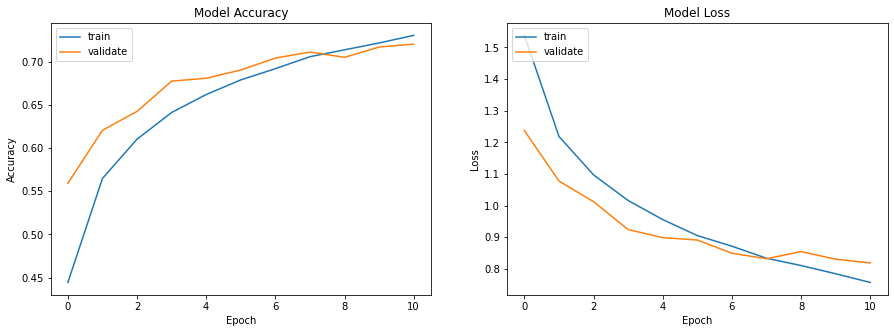

In [21]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [22]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8188 - accuracy: 0.7204
Test loss: 0.8187964558601379
Test accuracy: 0.7203999757766724


In [23]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

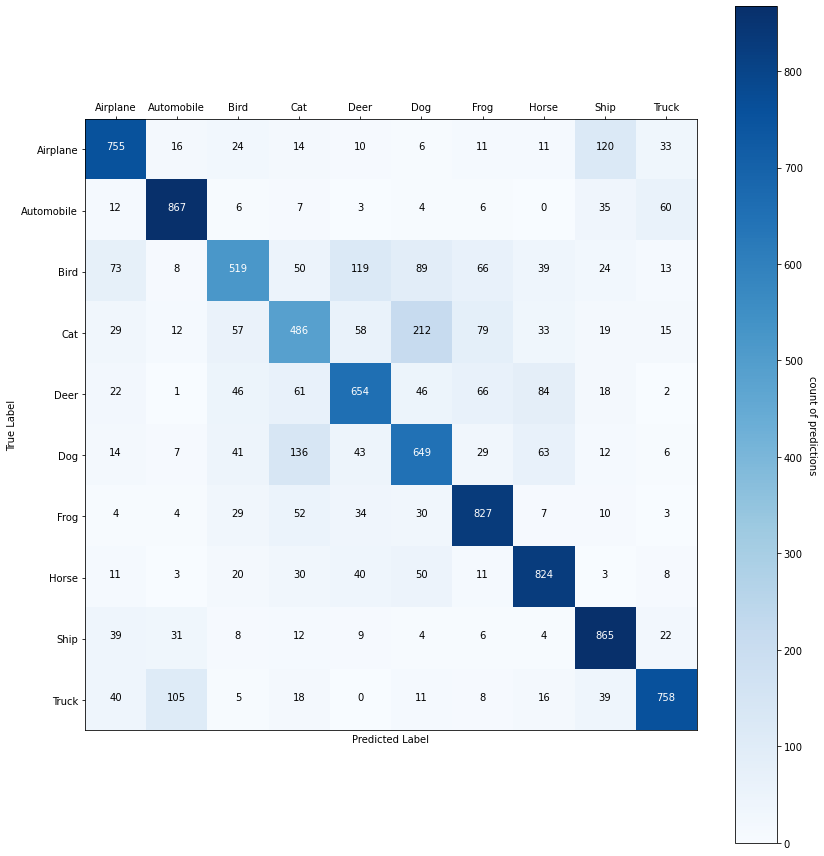

In [14]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [15]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1000
           1       0.82      0.87      0.84      1000
           2       0.69      0.52      0.59      1000
           3       0.56      0.49      0.52      1000
           4       0.67      0.65      0.66      1000
           5       0.59      0.65      0.62      1000
           6       0.75      0.83      0.78      1000
           7       0.76      0.82      0.79      1000
           8       0.76      0.86      0.81      1000
           9       0.82      0.76      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



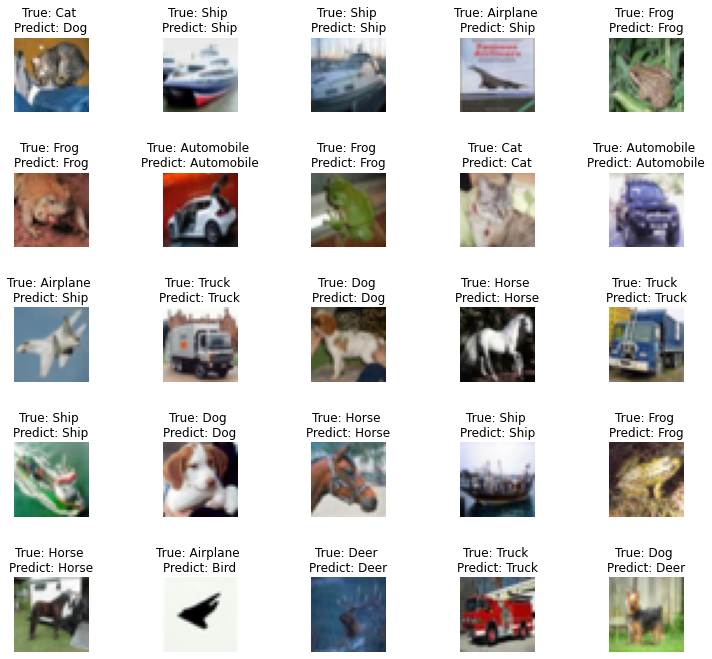

In [24]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

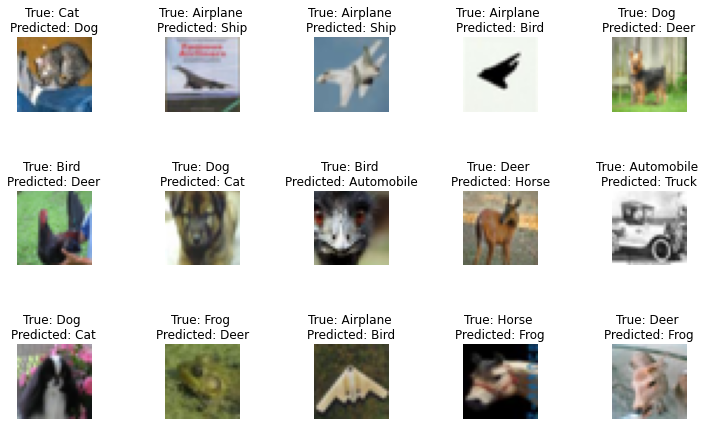

In [25]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

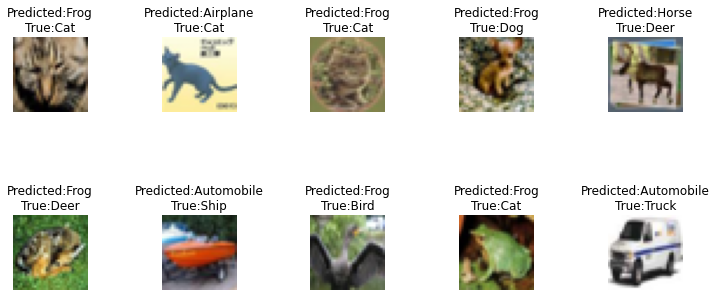

In [18]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [26]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

In [27]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at C:\Users\admin\Desktop\Programming\Python\pythonProject1\saved_models\keras_cifar10_trained_model.h5 
313/313 [==============================] - 1s 3ms/step - loss: 0.8188 - accuracy: 0.7204
Test loss: 0.8187964558601379
Test accuracy: 0.7203999757766724
